# Multiarmed bandit

**Mutliarmed bandit** is a type of reinforcement learning problem where the agent is faced with $k$ different options (actions) and its' objective is to maximise the reward given by taking those actions. A problem is logically represented by $k$ **bandits** (or one bandit with $k$ different 'options' to choose from) which are, for example, *slot machines* or *restaurants* in a new town etc. The agent interracts with bandits and, in return, gets his reward from them. Its' goal is to maximise gained reward over time spent interracting with bandits (concretely, **environment**). Therefore, it has to learn the optimal actions, so there are several approaches to deciding learning policies.

First of all, we're going to include needed `python` modules.

In [105]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Iterable, Callable, List, Dict, Tuple
from abc import ABC, abstractmethod, abstractstaticmethod

sns.set()

Now, we're going to define a `Bandit` class which represents a single instance of a bandit.

In [106]:
class Bandit:
    def __init__(self, mean : float, span : float) -> None:
        """
        Initialize the bandit.

        Regardless of the received action, the bandit will return reward 
        uniformly sampled from segment [`mean` - `span`, `mean` + `span`].

        Args:
            `mean` - Mean (expected) value of the reward.
            `span` - Span of the reward.
        """
        self.mean : float = mean
        self.span : float = span

    def pull_leaver(self) -> float:
        """
        Pull leaver and optain reward.

        Returns:
            The optained reward.
        """
        return self.mean + 2 * self.span * (random.random() - 0.5)

After we've defined the bandit, it's time to define bandit's environment.

In [107]:
class BanditsEnvironment:
    """An environment to multiple bandits."""

    def __init__(self, bandits : Iterable[Bandit], penalty : float = 1000.0, stationary : bool = True) -> None:
        """
        Initialize the environment. 

        Args:
            `bandits` - Bandits to be used within the environment.
            `penalty` - If the external agent attempts to use a bandit not in the list, 
                        i.e. if the choosen action is negative or bigger than the index of 
                        the last bandit, the returned rewards will be -`penalty`. 
                        Defaults to 1000.
            `stationary` - Is the environment stationary - does it not change over time?
                           Defaults to True.
        """
        self.bandits : List[Bandit] = list(bandits)
        self.penalty : float = penalty
        self.stationary : bool = stationary

    def take_action(self, a : int) -> None:
        """
        Select bandit `a` and pull its leaver. 
        
        If the selected agent is valid, return the obtained reward.
        Otherwise, return negative penalty.
        """
        if a < 0 or a >= len(self.bandits):
            return -self.penalty

        return self.bandits[a].pull_leaver()

    def change_env_chars(self, change_law : Callable[..., Tuple[float, float]], *args) -> None:
        """
        If self.stationary is set to False, it will change the 
        characteristics of bandits' environment according to passed
        law of change (could be stochastic or determinstic law).
        """

        if self.stationary:
            return

        for bandit in self.bandits:
            bandit.mean, bandit.span = change_law(*args)

A way which defines how agent takes actions is called **decision policy**. There are several decision policies for agent to take

- **Greedy action policy** - means than agent only takes a particular action with the highest return reward amongst ones it tried. This is called **exploitation** - agent *exploits* a particular action.
- **Random action policy** - means that agent takes random actions, with no particular order or rule. This is called **exploration** - agent *explores* multiple actions in space of all possible actions.
- $\epsilon$-**greedy action policy** - means that the agent primarily respects greedy action policy, but the probability for it to take a random action is not $0$, but some given $\epsilon$. This is a good stategy because the agent has both explorative and exploitative components - it can *exploit* the best action it found, but from time to time can try other to check if the new 'optimal' action has appeared in the mean time. This is cool if we know our optimal actions and just try to setup agent to learn it. One should be very careful with deciding the $\epsilon$ probability and not magnify it by a large value, because random action policy can turn out to be the worst amongst all policies.

We're going to make an interface for policies and implement each one in separate class, therefore obeying the 'Open-Closed' principle of writing object oriented designs.

In [108]:
from abc import ABC, abstractmethod, abstractstaticmethod

class Policy(ABC):
    """
    An interface for policies
    """

    @abstractstaticmethod
    def action(**kwargs) -> int:
        pass


class GreedyPolicy(Policy):
    def action(**kwargs) -> int:
        return np.argmax(kwargs['q'])
    

class RandomPolicy(Policy):
    def action(**kwargs) -> int:
        return random.randint(0, len(kwargs['q']) - 1)
    

class EpsGreedyPolicy(Policy):
    def action(**kwargs) -> int:
        if random.random() > kwargs['eps']:
            return GreedyPolicy.action(q=kwargs['q'])
        
        return RandomPolicy.action(q=kwargs['q'])

For plotting support, we're going to do the same as we did for policies - make an interface and implement concrete plots.

In [109]:
class Plot(ABC):
    """
    An interface for plots
    """

    @abstractmethod
    def plot(env : BanditsEnvironment, CHANGE_AT: List[int] = None, old_bandit_mean: List[List[float]] = None) -> None:
        pass


class RewardPlot(Plot):
    """
    Plot Mean/Q and Optimal/Taken actions relationships
    """

    def __init__(self, q : List[float], rewards : List[float]) -> None:
        self.rewards = rewards
        self.q = q

    def plot(self, env : BanditsEnvironment, CHANGE_AT: List[int] = None, old_bandit_mean: List[List[float]] = None) -> None:
        plt.scatter(range(len(env.bandits)), self.q, marker='.')
        plt.scatter(range(len(env.bandits)), [env.bandits[i].mean for i in range(len(env.bandits))], marker='x')

        plt.show()

        g = np.cumsum(self.rewards)
        max_r = max([b.mean for b in env.bandits])

        plt.figure(figsize=(20,6))
        plt.plot(g)

        legend = ['Collected rewards']

        if not env.stationary:
            for i, old_mean in enumerate(old_bandit_mean):
                old_max_r = max(old_mean)
                plt.plot(np.cumsum(old_max_r * np.ones(len(g))))
                plt.axvline(x=CHANGE_AT[i], ymin=0.05, ymax=0.95, linestyle='dashed', color='red', label='_nolegend_')
                
                legend.append(f'Maximum reward before {i + 1}th change')
                
        plt.plot(np.cumsum(max_r * np.ones(len(g))))
        legend.append('Final maximum reward')

        plt.legend(legend, loc='best')
        plt.show()


class ConvergencePlot(Plot):
    """
    Plotting convergence of Q for a `bandit_id` to its' mean value.
    The largest in length x-axis will show what bandit was played the most and we expect his mean value to be 
    the biggest amongst all.
    """

    def __init__(self, q_evol : List[Dict[int, List[float]]], eps : float, ATTEMPTS_NO : int) -> None:
        self.q_evol = q_evol
        self.eps = eps
        self.ATTEMPTS_NO = ATTEMPTS_NO

    def plot(self, env : BanditsEnvironment, CHANGE_AT: List[int] = None, old_bandit_mean: List[List[float]] = None) -> None:
        plt.figure(figsize=(20,12))
        legend = []
        start = 0

        colors = sns.color_palette('husl', n_colors=len(env.bandits))

        for i, bandit in enumerate(env.bandits):
            if CHANGE_AT:
                for j in range(len(CHANGE_AT)):
                    xaxis = [k for k in range(start, CHANGE_AT[j])]
                    for k, old_mean in enumerate(old_bandit_mean[j]):
                        plt.plot(xaxis, 
                                old_mean * np.ones(len(xaxis)), 
                                linestyle='--', label='_nolegend_',
                                color=colors[k])
                    start = CHANGE_AT[j]
            plt.plot(range(CHANGE_AT[-1] if CHANGE_AT else 0, self.ATTEMPTS_NO), 
                        bandit.mean * np.ones(self.ATTEMPTS_NO - CHANGE_AT[-1] if CHANGE_AT else self.ATTEMPTS_NO), 
                        linestyle='--', label='_nolegend_',
                        color=colors[i])
            plt.scatter([i for i in range(self.ATTEMPTS_NO + 1)], self.q_evol[i], marker='.', s=10, color=colors[i])
            legend.append(f'Q over time for bandit {i}')

        plt.legend(legend, loc='best')
        plt.show()

As we have defined all the substantial things we need, now we move to defining a system to test bandits.

In [110]:
class System:
    """
    Here we will implement the whole system (environment). If the 
    environment has variable characteristics, the logic for 
    that will be implemented here.
    """
    def __init__(self, bandits : List[Bandit], stationary : bool = True, ALPHA : float = 0.1):
        self.env = BanditsEnvironment(bandits, stationary=stationary)
        self.ALPHA = ALPHA
        
    def run_system(self, eps : float = 0, ATTEMPTS_NO : int = 10000, CHANGE_AT : List = None):
        if CHANGE_AT: 
            CHANGE_AT = list(CHANGE_AT)
            chiter = 0

        q = [0 for _ in range(len(self.env.bandits))]
        q_evol = {i: [0] for i in range(len(self.env.bandits))}
        rewards = []
        old_bandit_mean = []

        if not self.env.stationary:
            def change_law():
                return 10 * (random.random() - 0.5), 5 * random.random()

        for attempt in range(ATTEMPTS_NO):
            
            if CHANGE_AT:
                if attempt == CHANGE_AT[chiter] and not self.env.stationary:
                    old_bandit_mean.append([b.mean for b in self.env.bandits])
                    self.env.change_env_chars(change_law)
                    chiter = chiter + 1 if chiter + 1 < len(CHANGE_AT) else 0

            a = EpsGreedyPolicy.action(q=q, eps=eps)
            r = self.env.take_action(a)

            q[a] = q[a] + self.ALPHA * (r - q[a])

            for i in range(len(self.env.bandits)):
                if i == a:
                    q_evol[i].append(q[a])
                else:
                    q_evol[i].append(None)

            rewards.append(r)

        if not self.env.stationary:
            plotter = RewardPlot(rewards=rewards, q=q)
            plotter.plot(env=self.env, CHANGE_AT=CHANGE_AT, old_bandit_mean=old_bandit_mean)
        else:
            plotter = RewardPlot(rewards=rewards, q=q)
            plotter.plot(env=self.env)

        return q, q_evol, old_bandit_mean

It's time for **testing**!

In [111]:
import unittest

class TestMultiarmBandits(unittest.TestCase):
    """
    A class for testing multiarm bandit
    """
    def test_single_bandit(self) -> None:
        """
        Testing a single bandit.
        """
        test_mean = 1.0
        test_span = 3.0
        test_len = 1000

        test_bandit = Bandit(test_mean, test_span)
        test_rewards = [test_bandit.pull_leaver() for _ in range(test_len)]
        
        plt.plot(test_rewards, label = 'rewards')
        plt.plot((test_mean + test_span) * np.ones(test_len), linestyle = '--', color = 'red')
        plt.plot((test_mean - test_span) * np.ones(test_len), linestyle = '--', color = 'red')

        plt.show()

    def test_environment(self) -> None:
        """
        Testing bandits' environment. 
        """
        test_env_size = 5
        test_bandits = [Bandit(i**2, i) for i in range(test_env_size)]
        test_env = BanditsEnvironment(test_bandits)
        test_len = 1000

        selected_bandit = 4
        test_rewards = [test_env.take_action(selected_bandit) for _ in range(test_len)]

        plt.plot(test_rewards, label = 'rewards')
        plt.plot((selected_bandit**2 + selected_bandit) * np.ones(test_len), linestyle = '--' , color = 'r')
        plt.plot((selected_bandit**2 - selected_bandit) * np.ones(test_len), linestyle = '--' , color = 'r')

        plt.show()

        test_rewards = [test_env.take_action(random.randint(0, 4)) for _ in range(test_len)]
        test_mean = sum(test_rewards) / test_len

        print("TEST MEAN = ", test_mean)

    def test_decision_policies(self) -> None:
        """
        Testing decision policies.
        """
        test_q = [1, 2, 3, 2, 1]
        test_len = 1000

        plt.subplot(3, 1, 1)
        plt.plot([GreedyPolicy.action(q=test_q) for _ in range(test_len)])
        plt.subplot(3, 1, 2)
        plt.plot([RandomPolicy.action(q=test_q) for _ in range(test_len)])
        plt.subplot(3, 1, 3) 
        plt.plot([EpsGreedyPolicy.action(q=test_q, eps=0.1) for _ in range(test_len)])

        plt.show()

    def test_system(self) -> None:

        BANDITS_NO = 5
        ATTEMPTS_NO = 10000

        bandits = [Bandit(10 * (random.random() - 0.5), 5 * random.random()) for i in range(BANDITS_NO)]
        sys = System(bandits)

        #  *** 1. zadatak *** 
        # Razlog manjeg nagiba jeste što smanjivanjem epsilon vrijednosti smanjujemo eksploraciju i držimo se 
        # eksploatacije, te u tom slučaju kriva će biti bliža "optimalnoj".
        # Prikazujemo i grafik konvergencije, koji pokazuje suštinu epsilon greedy politike.

        print('*** 1. zadatak ***')
        
        test_eps = [0.7, 0.4, 0.1, 0.01]
        
        for eps in test_eps:
            q, q_evol, old_bandit_mean = sys.run_system(eps=eps, ATTEMPTS_NO = ATTEMPTS_NO)
            plotter = ConvergencePlot(q_evol=q_evol, eps=0.1, ATTEMPTS_NO=ATTEMPTS_NO)
            plotter.plot(env=sys.env)

        # *** 2. zadatak ***
        # Naučeno Q vs epsilon = 0.

        print('*** 2. zadatak ***')

        test_eps = [0.1, 0.0]
        
        for eps in test_eps:
            q, q_evol, old_bandit_mean = sys.run_system(eps = eps, ATTEMPTS_NO = ATTEMPTS_NO)
            
        # *** 3. zadatak ***
        # Šta ako su karakteristike bandita promjenljive u vremenu?
        # Definišimo zakon promjene srednjih vrijednosti (može biti stohastičke ili determinističke prirode).
        # U tom slučaju ima smisla davati veću težinu trenutnim nagradama 
        # kako bi se pokušala pronaći trenutno optimalna akcija. 
        # Stoga se zadaje težinski faktor ALPHA,
        # koji je već implementiran i u nestacionarnom slučaju.
        # Takođe je potrebno izmijeniti implementaciju klase BanditEnvironment
        # kako bismo dodali mogućnost mijenjanja okoline.

        print('*** 3. zadatak ***')

        bandits = [Bandit(10 * (random.random() - 0.5), 5 * random.random()) for i in range(BANDITS_NO)]
        sys = System(bandits, stationary = False)
        CHANGE_AT = [4000, 6000, 9000]
        q, q_evol, old_bandit_mean = sys.run_system(eps = 0.1, CHANGE_AT=CHANGE_AT)


        # *** 4. zadatak ***
        # Konvergencija Q vrijednosti ka srednjoj vrijednosti bandita. U ovom slučaju
        # uzimamo prethodni sistem koji je stohastičke prirode, te ćemo dobiti 
        # ponašanje da Q vrijednosti pokušavaju konvergirati ka srednjoj vrijednosti.

        print('*** 4. zadatak ***')
        plotter = ConvergencePlot(q_evol=q_evol, eps=0.1, ATTEMPTS_NO=ATTEMPTS_NO)
        plotter.plot(env=sys.env, CHANGE_AT=CHANGE_AT, old_bandit_mean=old_bandit_mean)
        

test_decision_policies (__main__.TestMultiarmBandits.test_decision_policies)
Testing decision policies. ... 

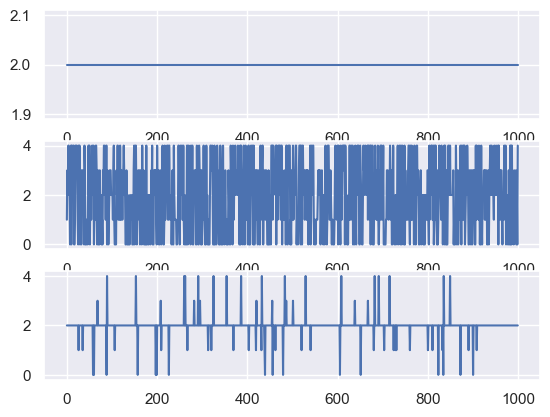

ok
test_environment (__main__.TestMultiarmBandits.test_environment)
Testing bandits' environment. ... 

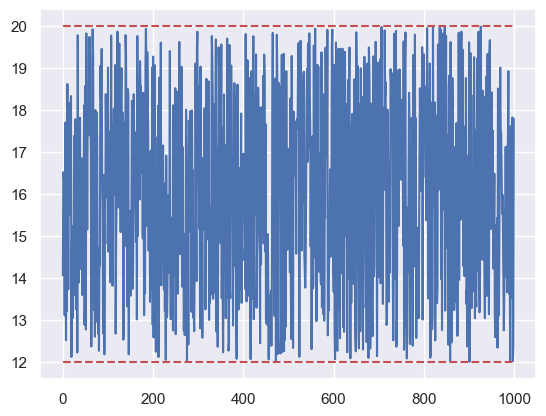

ok
test_single_bandit (__main__.TestMultiarmBandits.test_single_bandit)
Testing a single bandit. ... 

TEST MEAN =  5.893081263711139


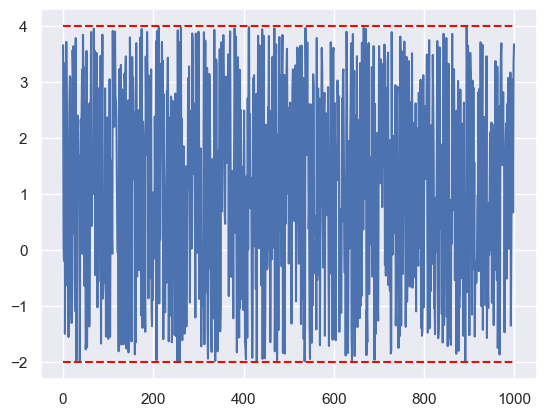

ok
test_system (__main__.TestMultiarmBandits.test_system) ... 

*** 1. zadatak ***


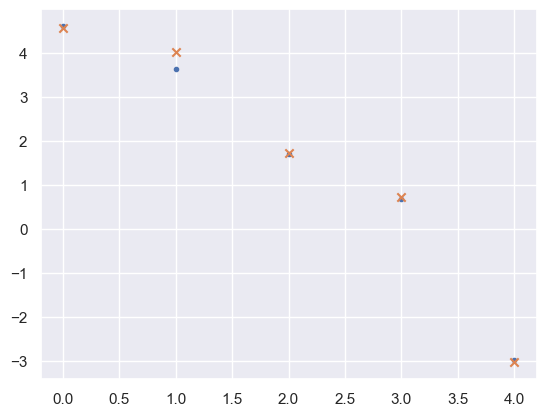

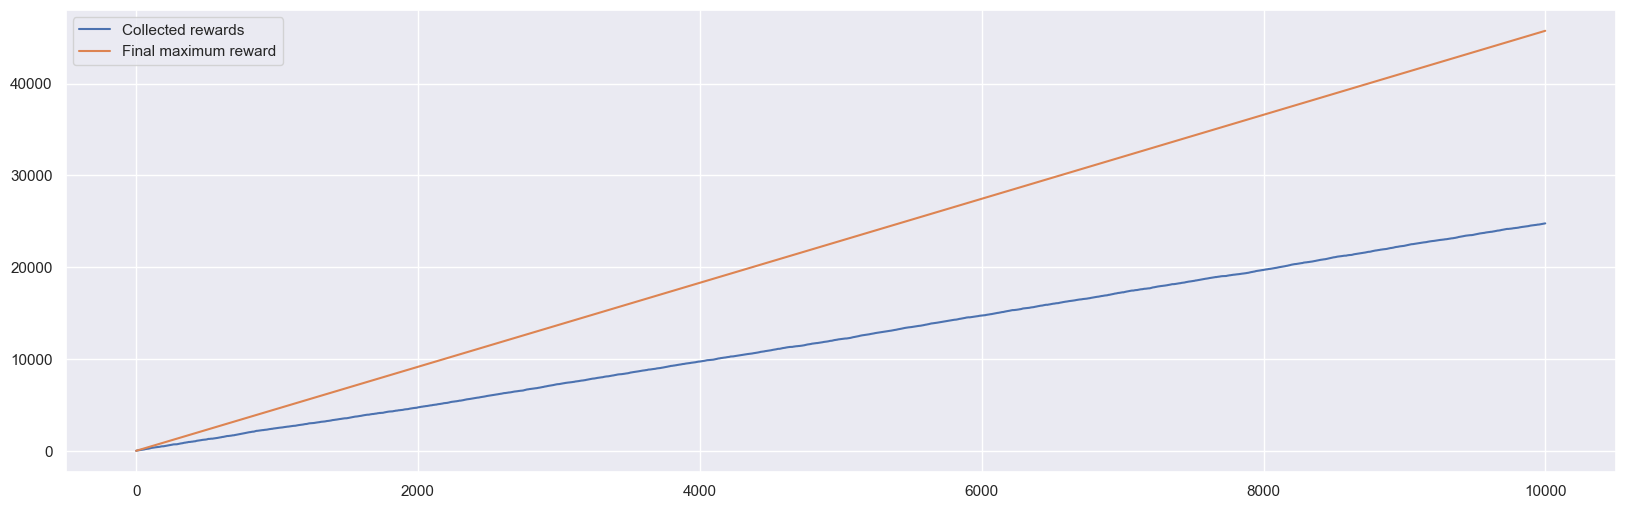

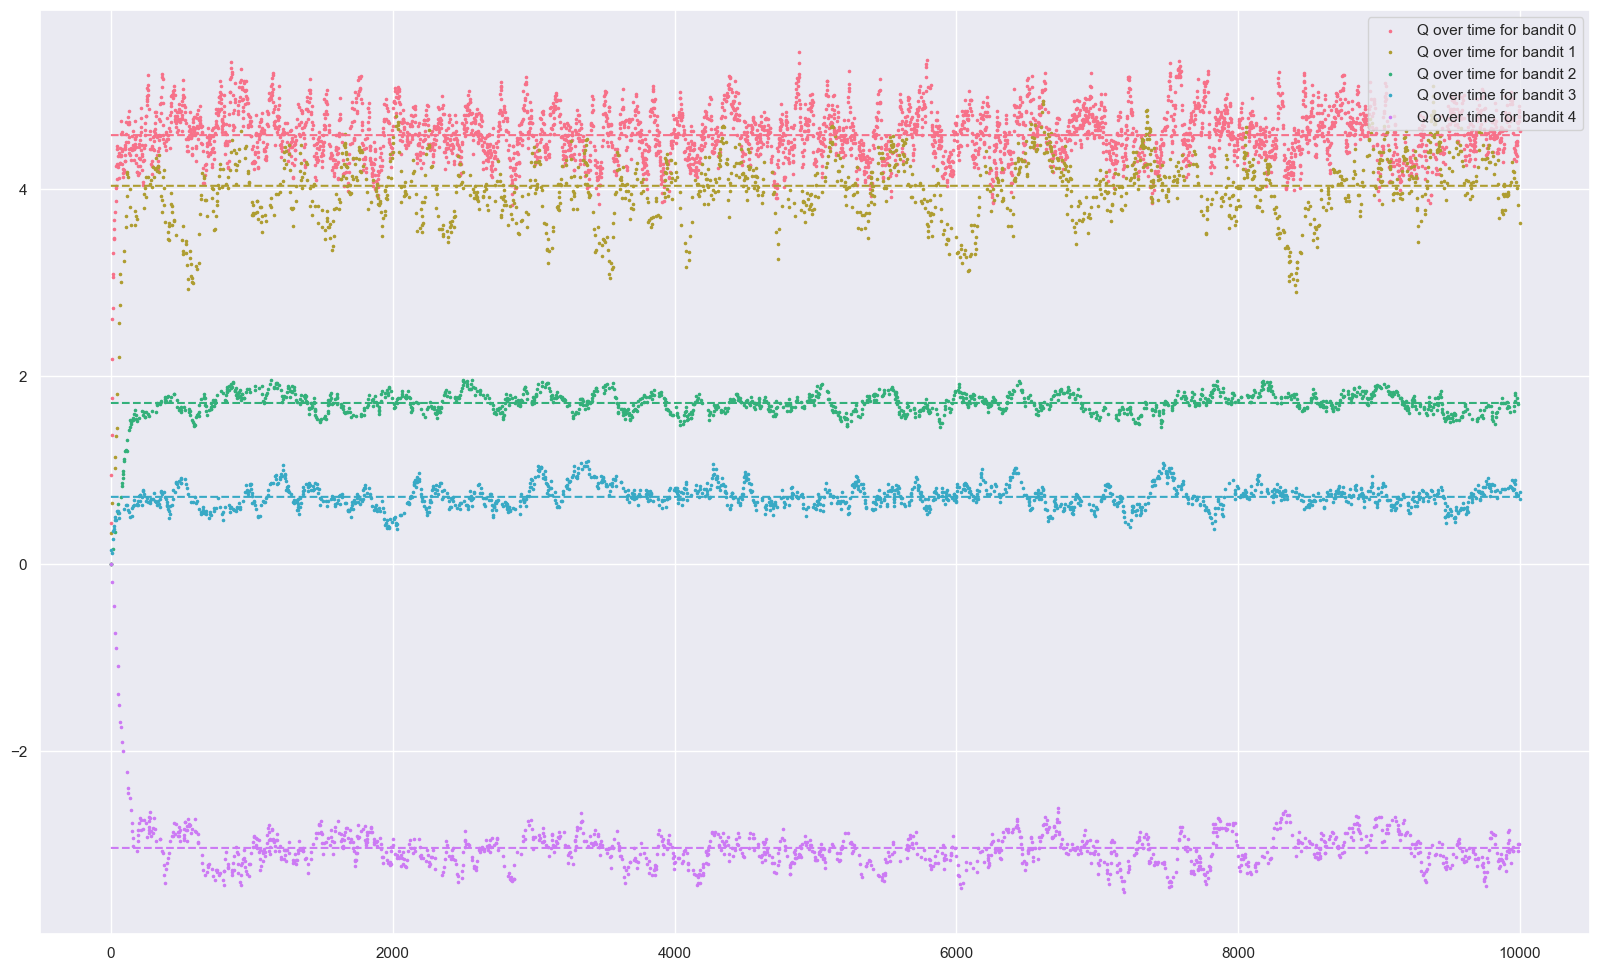

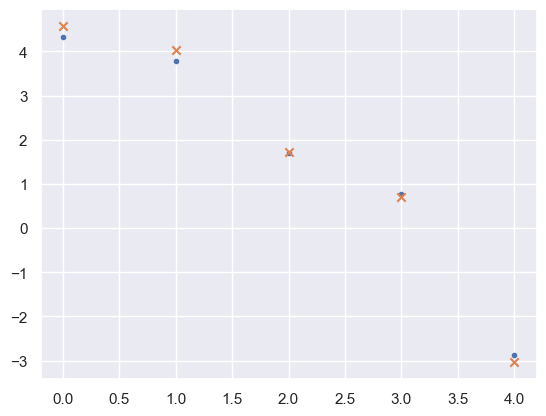

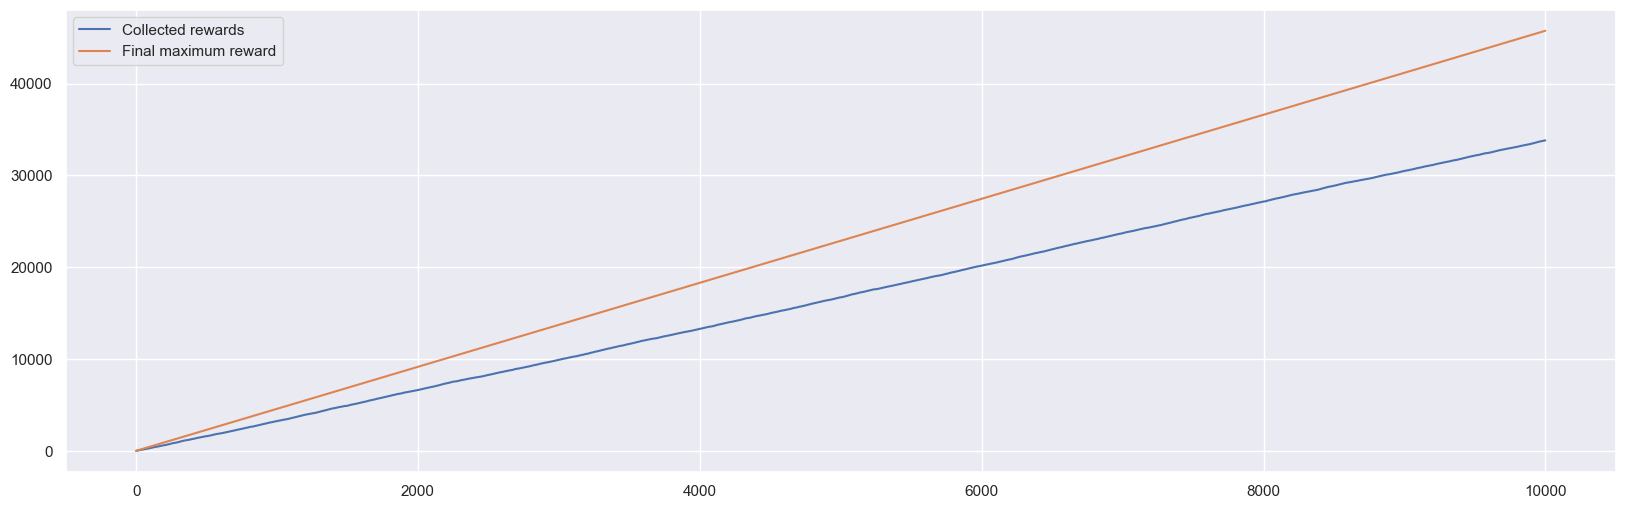

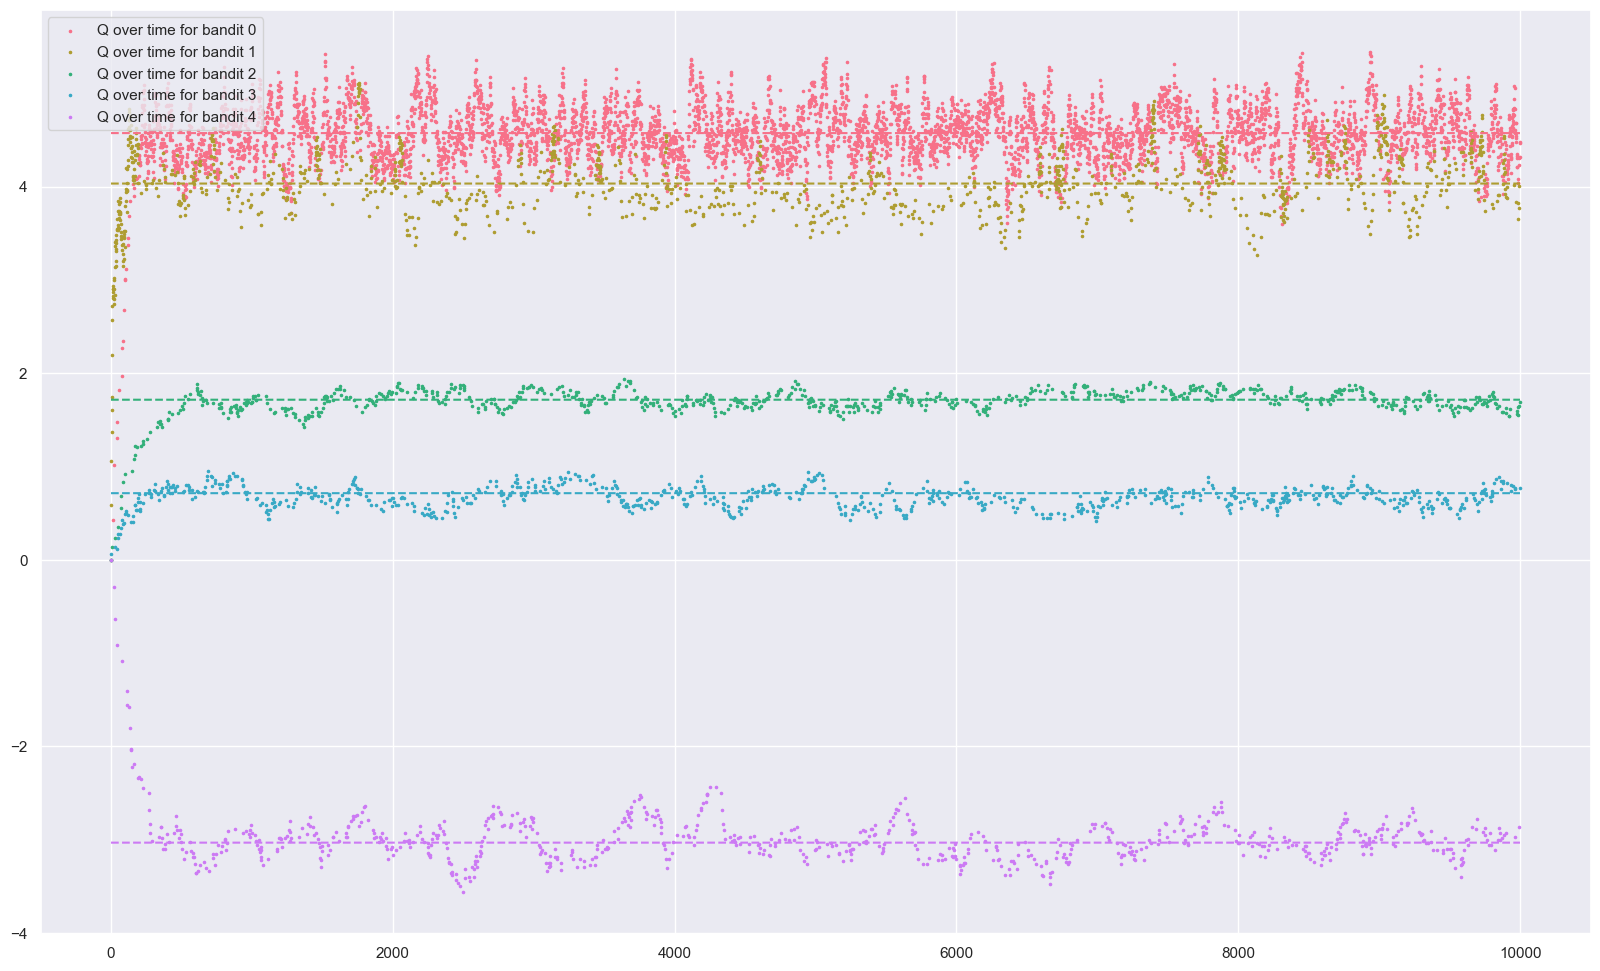

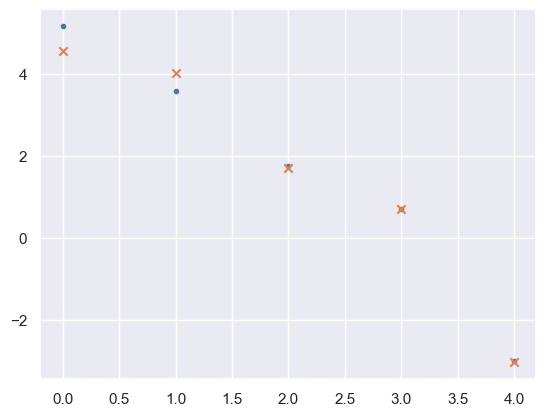

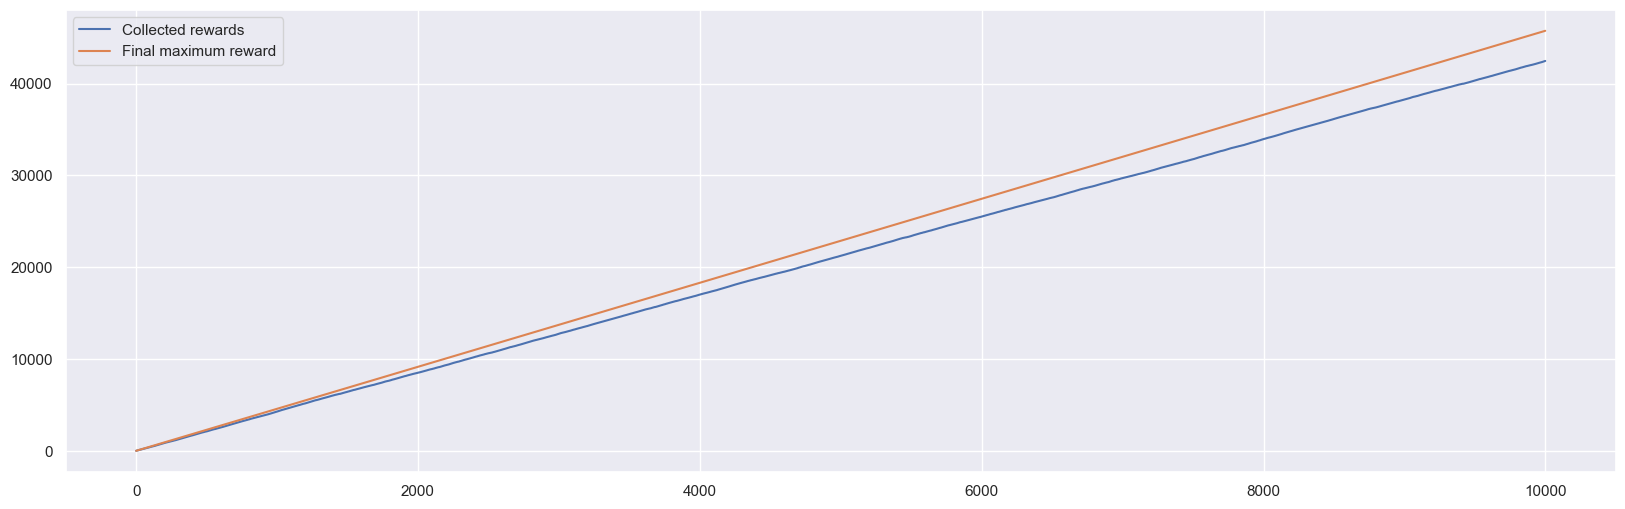

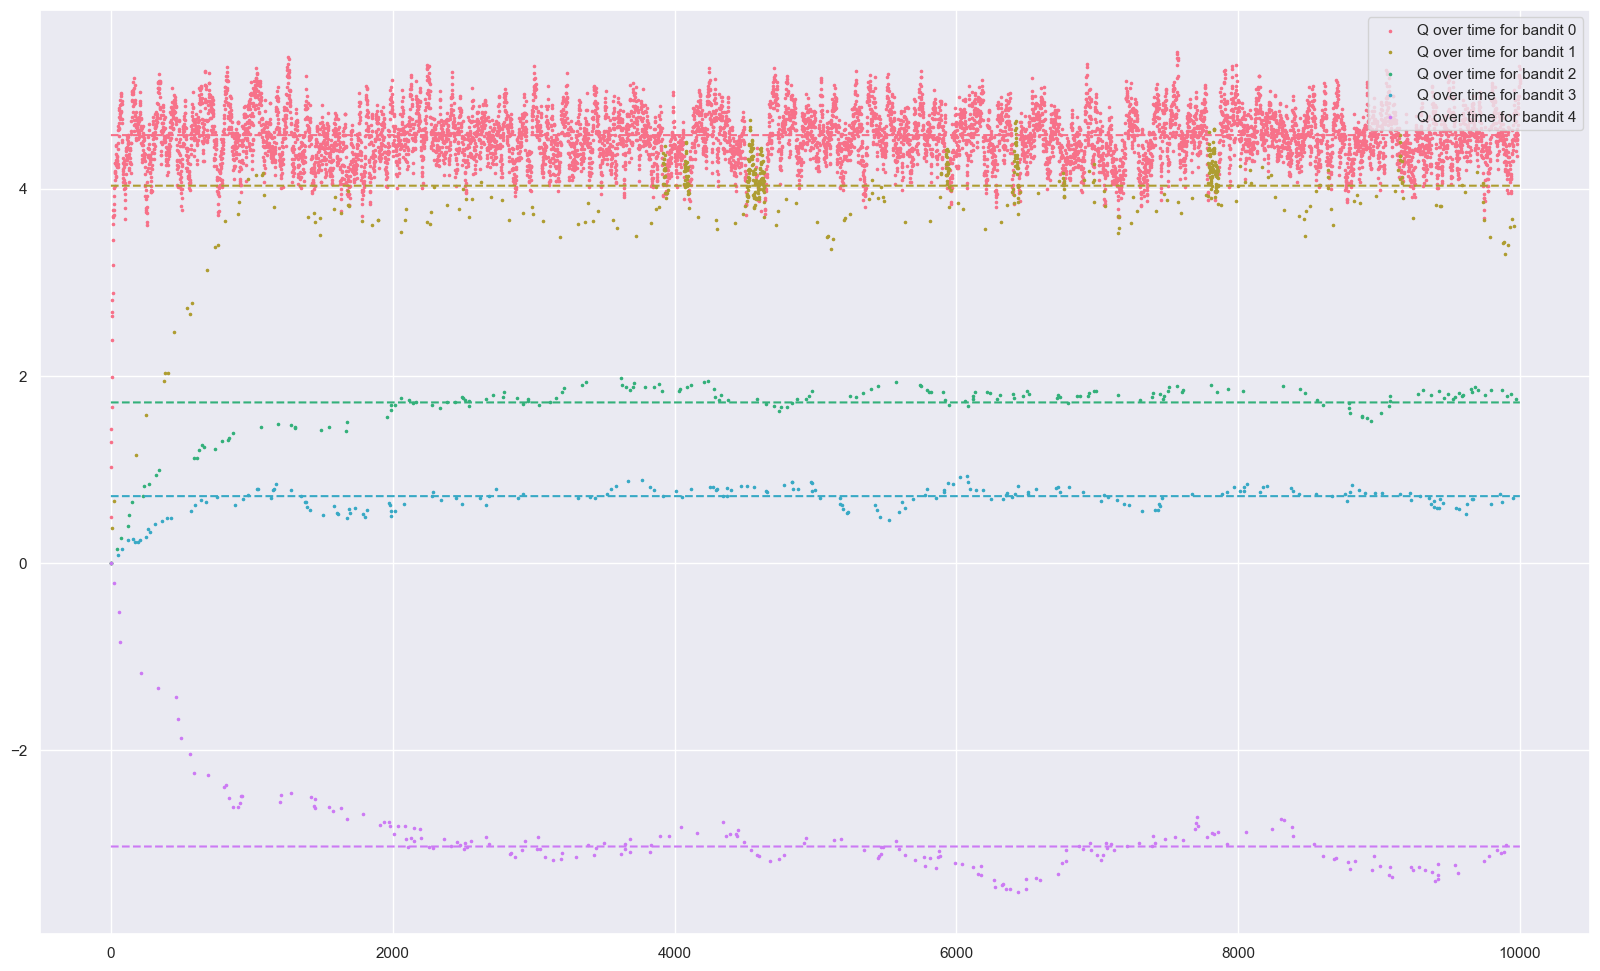

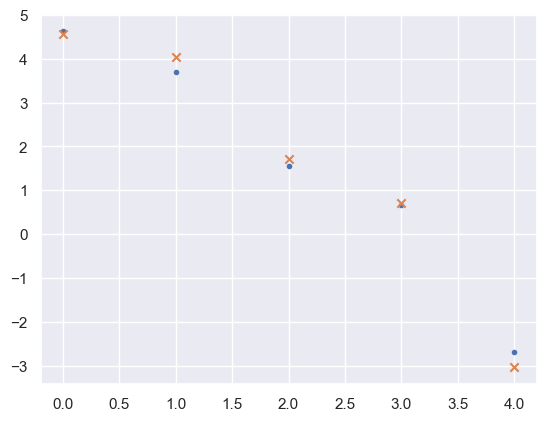

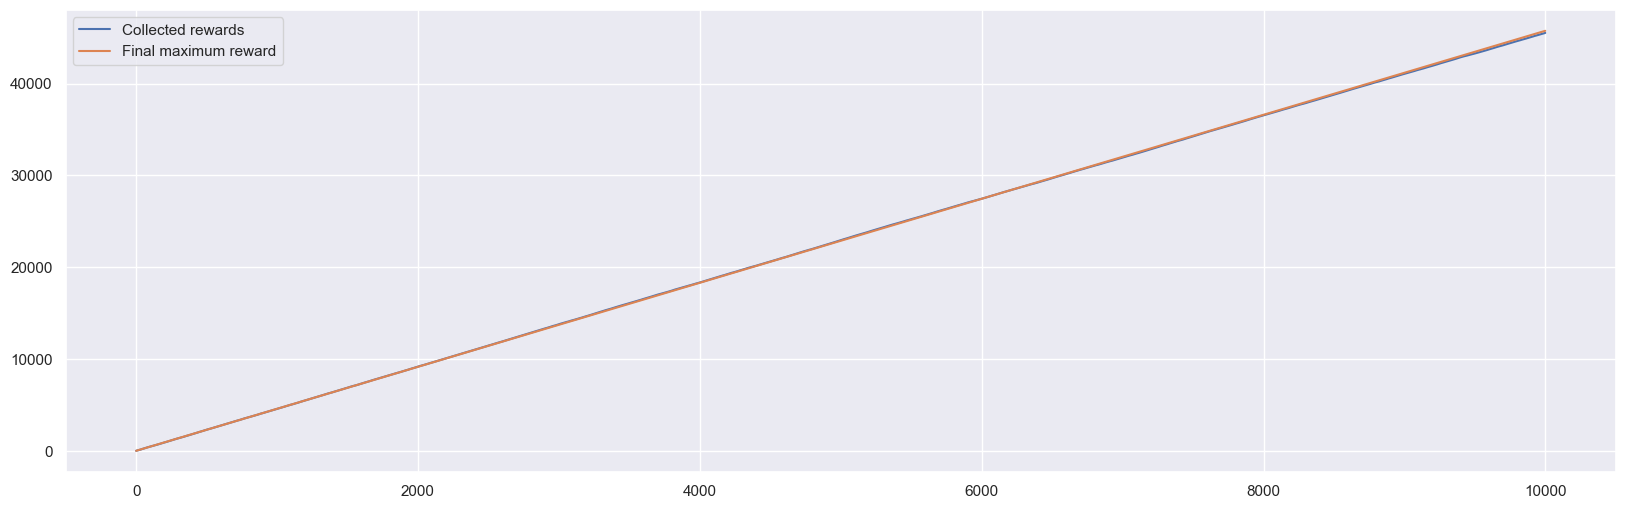

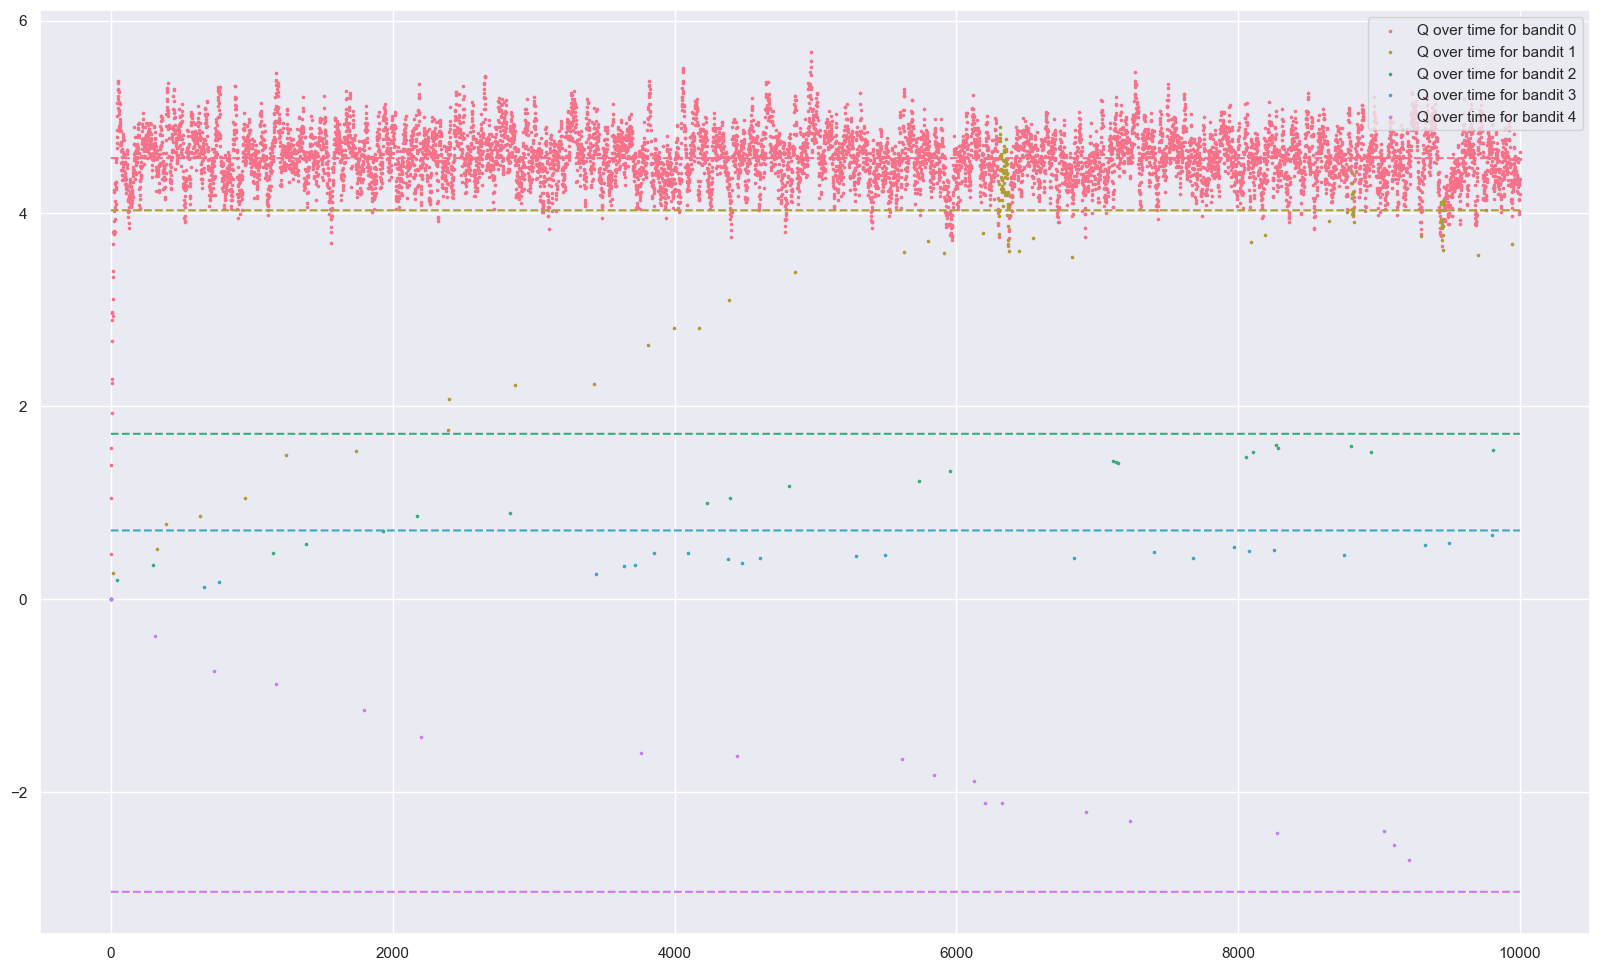

*** 2. zadatak ***


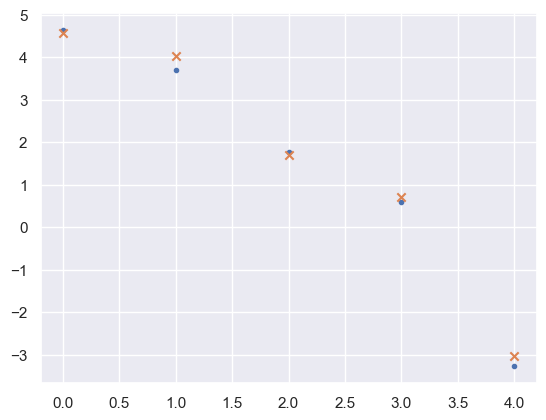

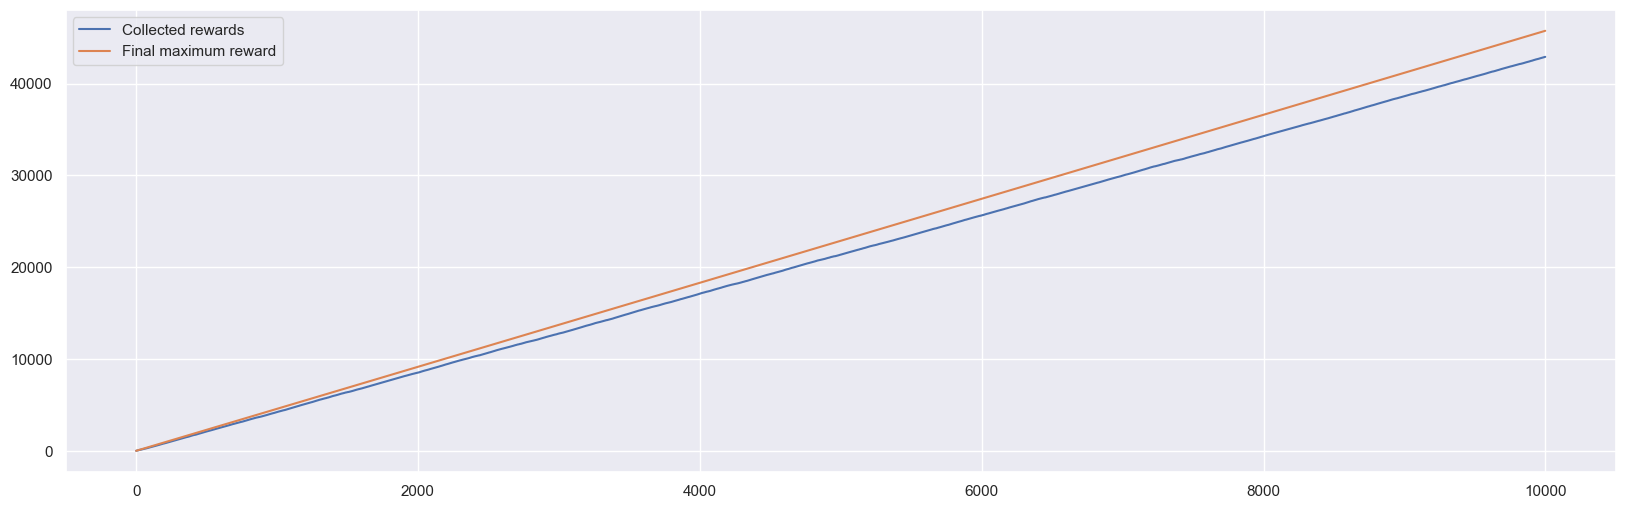

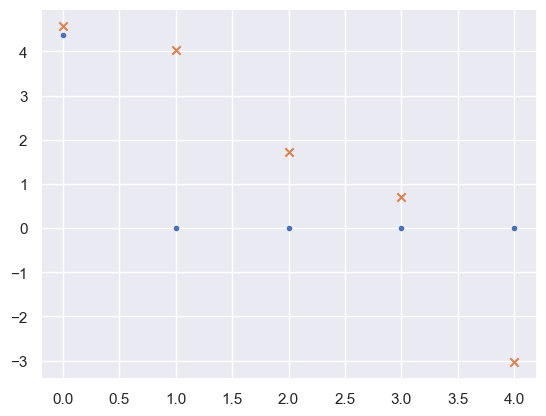

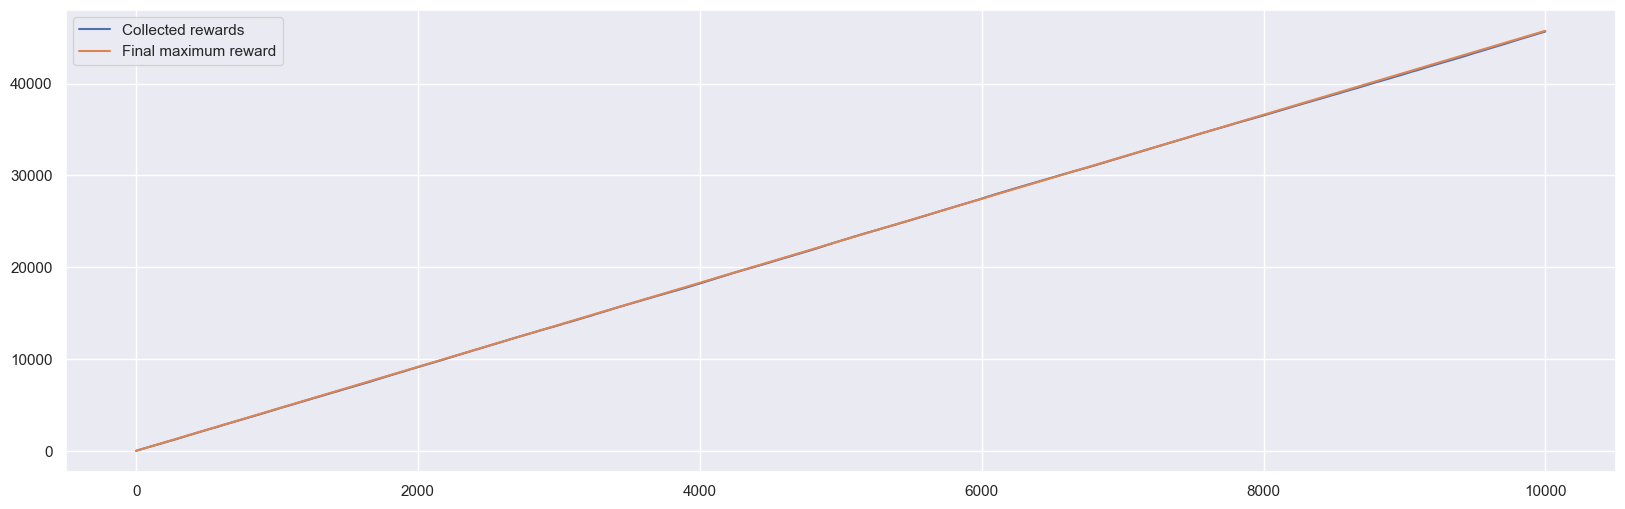

*** 3. zadatak ***


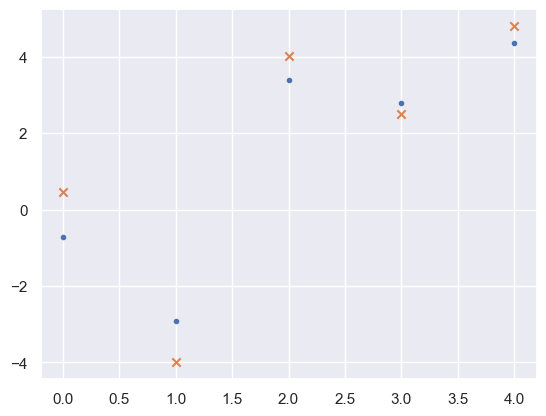

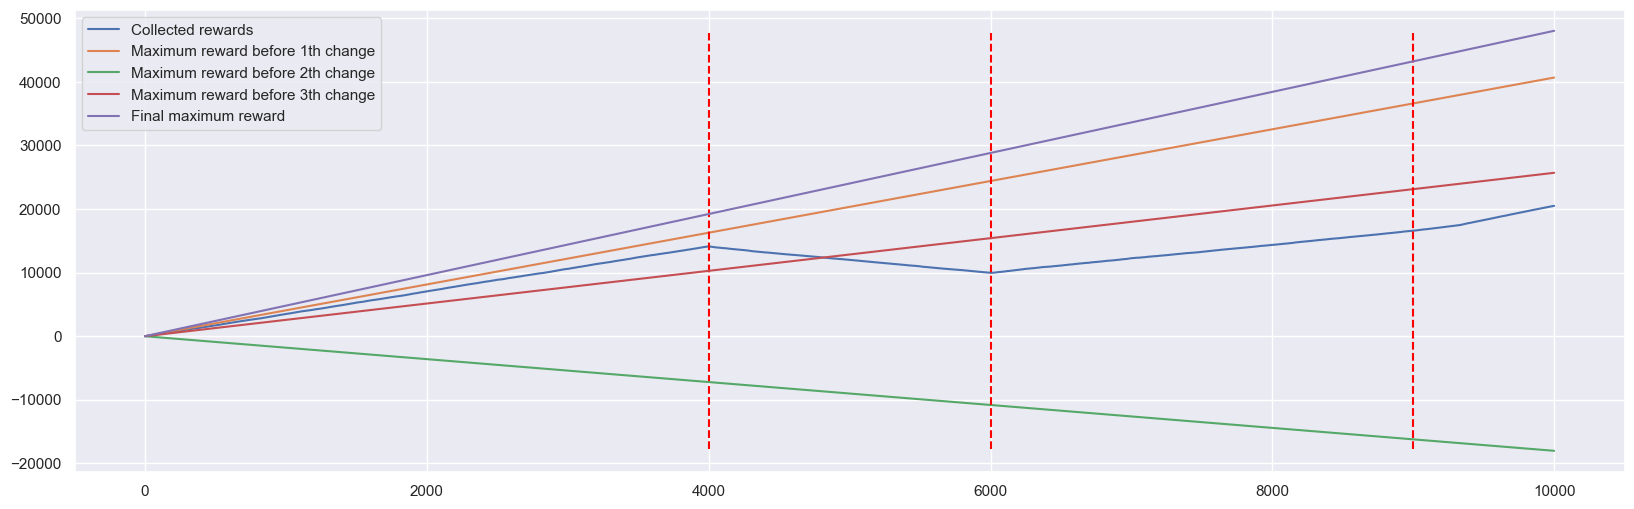

*** 4. zadatak ***


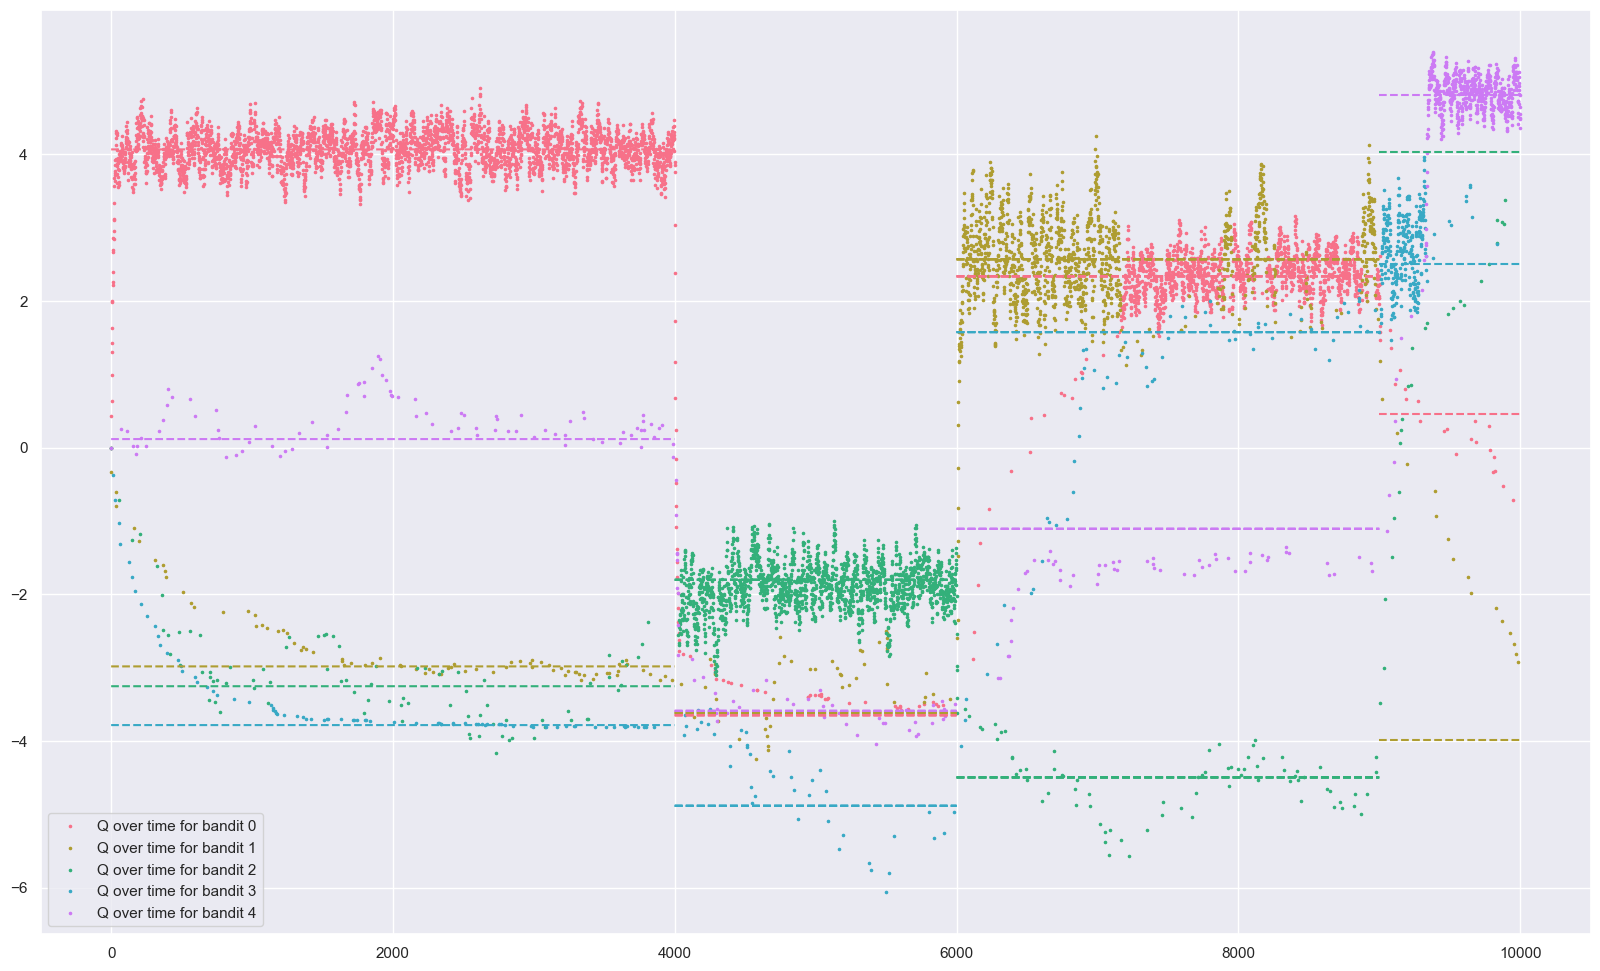

ok

----------------------------------------------------------------------
Ran 4 tests in 10.107s

OK


In [112]:
unittest.main(argv = [''], verbosity = 2, exit = False)